# I-DATA PREPARATION

## I-1 Loading Data

In [129]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import scipy.fftpack
import datetime as dt
import scipy.stats
import datetime
import scipy.interpolate as intr

In [130]:
#Container clean data
TT=pandas.read_csv("TT2.csv")
#container processed data
TTc=pandas.read_csv("TT2.csv")

In [131]:
TT['DATE'] = TT['DATE'].apply(lambda x: 
                                 dt.datetime.strptime(x,'%d/%m/%Y'))
TTc['DATE'] = TTc['DATE'].apply(lambda x: 
                                 dt.datetime.strptime(x,'%d/%m/%Y'))   
TTc=TTc.set_index('DATE').asfreq("D")

In [132]:
plt.figure(0)
ax0=plt.subplot(312)
plt.plot(TTc["TAVE"],color="r")
plt.title("Temp. AVE._RAW DATA")
plt.xticks(rotation="horizontal")
plt.tight_layout()
plt.ylabel("ºC")

ax0=plt.subplot(311)
plt.title("Temp. Max._RAW DATA")   
plt.plot(TTc["TMAX"],color="b")
plt.tight_layout()
plt.ylabel("ºC")

ax0=plt.subplot(313)
plt.title("Temp. Min._RAW DATA")   
plt.plot(TTc["TMIN"],color="m")
plt.tight_layout()
plt.ylabel("ºC")


There are several anomalies in the Temperature raw data: outliers & gaps.

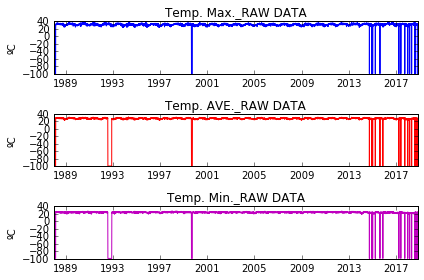

In [133]:
plt.show()

The same goes for the precipitation and radiation.

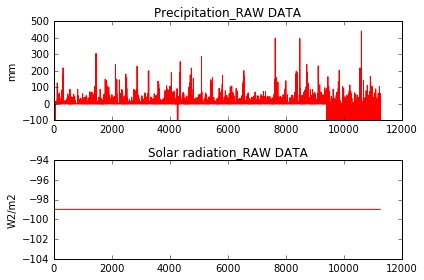

In [134]:
plt.figure(1)
ax2=plt.subplot(212)
plt.title("Solar radiation_RAW DATA")   
plt.plot(TT["SRAD"],color="r")
plt.xticks(rotation="horizontal")
plt.tight_layout()
plt.ylabel("W2/m2")

ax2=plt.subplot(211)
plt.title("Precipitation_RAW DATA")   
plt.plot(TT["RAIN"],color="r")
plt.xticks(rotation="horizontal")
plt.tight_layout()
plt.ylabel("mm")
plt.show()

## I-2 Outliers detection

### I-2-a Absolute Values Method 

A reasonable range of temperatures is selected = 15-50.
Values ouside this range are considered outliers and marked as NAN.

In [135]:
def func0(x):
    if x>15 and x<50:
        return x
    else:
        return np.nan
        
        
def func1(x):
    if x>1:
        return x
    else:
        return 0    

TTc = TTc.assign(TAVE_ABS=TTc.TAVE)

TTc["TAVE_ABS"]=TTc["TAVE_ABS"].apply(lambda x:func0(x))
count_nan = len(TTc.TAVE_ABS) - TTc.TAVE_ABS.count()
TTc["TAVE"]=TTc["TAVE"].apply(lambda x:func0(x))
TTc["TMAX"]=TTc["TMAX"].apply(lambda x:func0(x))
TTc["TMIN"]=TTc["TMIN"].apply(lambda x:func0(x))
TTc["RAIN"]=TTc["RAIN"].apply(lambda x:func1(x))

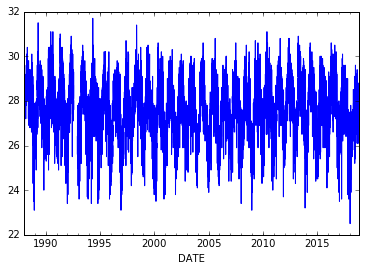

In [136]:
TTc.TAVE.plot()
plt.show()

The number of anomalies identified (1st column=position, 2nd column=number anomalies in subsequent positions):

In [326]:
ABS_G=TTc.TAVE_ABS.isnull().astype(int).groupby(TTc.TAVE_ABS.notnull().astype(int).cumsum()).sum()
ABS_G=ABS_G[ABS_G!=0]
print(ABS_G)

TAVE_ABS
31        29
1645     122
4110      30
9588       1
9662       1
9687       1
9768       1
9911       1
10000      1
10494      2
10554      1
10675      1
10766      1
10824      1
10884      1
10975      1
11005      1
11030     14
11051      1
Name: TAVE_ABS, dtype: int32


### I-2-b Return Period Method

The strategy is calculating the return period (T) for the extreme events (T_Max and T_Min) in the Data, selecting a design T and remove all values outside this range (T_Max(T) - T_Min (T)).


In [138]:
#ANNUAL MAXIMUM
Datap=pandas.Series(TTc.resample('365D').max().TMAX.values.ravel())
Datap.plot()

This is the variation of the annual Tmax. 

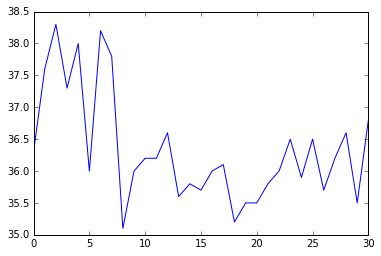

In [139]:
plt.show()

Finding a Parametric Distribution that better fits these data (Non-parametric distribution is not required).

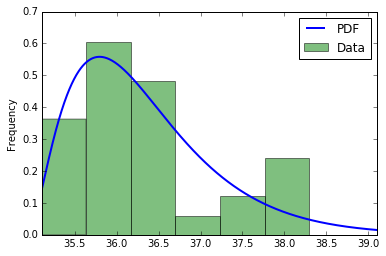

In [140]:
T=50
dist=scipy.stats.pearson3
# Get histogram of original data
y, x = np.histogram(Datap, bins=6, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0
#Calculate Parameters
params = dist.fit(Datap)
arg = params[:-2]
loc = params[-2]
scale = params[-1]
# Calculate fitted PDF and error with fit in distribution
ypdf = dist.pdf(x, loc=loc, scale=scale, *arg)
sse = np.sum(np.power(y - ypdf, 2.0))
# Get sane start and end points of distribution
start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)
# Build PDF and turn into pandas Series
x1 = np.linspace(start, end, 1000)
y1 = dist.pdf(x1, loc=loc, scale=scale, *arg)
pdf = pandas.Series(y1, x1)
# Display
ax = pdf.plot(lw=2, label='PDF', legend=True)
Datap.plot(kind='hist', bins=6, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)
dataYLim = ax.get_ylim
plt.show()


The Return Period T for and event X>Tmax

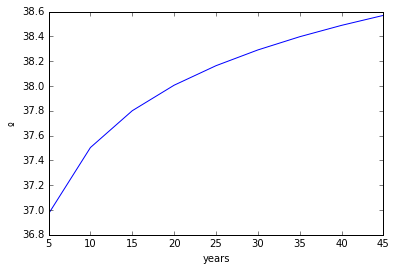

In [141]:
T=np.arange(5,50,5)
TMAXT=dist.ppf(1-1/T, loc=loc, scale=scale, *arg)
plt.plot(T,TMAXT)
plt.xlabel("years")
plt.ylabel("º")
plt.show()

In [142]:
#ANNUAL MINIMUM 
Datapm=pandas.Series(TTc.resample('365D').min().TMIN.values.ravel())
dist=scipy.stats.chi
# Get histogram of original data
y, x = np.histogram(Datapm, bins=6, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0
#Calculate Parameters
params = dist.fit(Datapm)
arg = params[:-2]
loc = params[-2]
scale = params[-1]
# Calculate fitted PDF and error with fit in distribution
ypdf = dist.pdf(x, loc=loc, scale=scale, *arg)
sse = np.sum(np.power(y - ypdf, 2.0))
# Get sane start and end points of distribution
start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)
# Build PDF and turn into pandas Series
x1 = np.linspace(start, end, 1000)
y1 = dist.pdf(x1, loc=loc, scale=scale, *arg)
pdf = pandas.Series(y1, x1)
# Display
#plt.figure(5)
#ax = pdf.plot(lw=2, label='PDF', legend=True)
#Datap.plot(kind='hist', bins=6, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)
#dataYLim = ax.get_ylim
#TMIN for Return Period T
TMINT=dist.ppf(1-1/T, loc=loc, scale=scale, *arg)

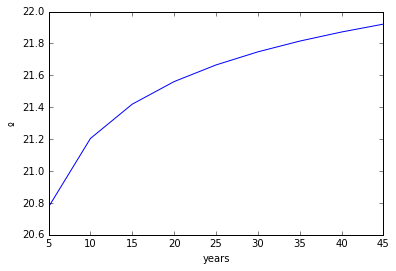

In [143]:
T=np.arange(5,50,5)
TMINT=dist.ppf(1-1/T, loc=loc, scale=scale, *arg)
plt.plot(T,TMINT)
plt.xlabel("years")
plt.ylabel("º")
plt.show()

As a design criteria T=15 years is selected and outliers outside the range are removed.

In [144]:
T=10
TMAXT=dist.ppf(1-1/T, loc=loc, scale=scale, *arg)
TMINT=dist.ppf(1-1/T, loc=loc, scale=scale, *arg)

#REMOVING OUTLIERS
def func3(x):
    if x>TMINT and x<TMAXT+Freeway:
        return x
    else:
        return np.nan
    
TTc = TTc.assign(TAVE_T=TTc.TAVE)    
TTc["TAVE_T"]=TTc["TAVE_T"].apply(lambda x:func0(x))   

The number of anomalies identified (1st column=position, 2nd column=number anomalies in subsequent positions):

In [145]:
T_G=TTc.TAVE_T.isnull().astype(int).groupby(TTc.TAVE_T.notnull().astype(int).cumsum()).sum()
T_G=T_G[T_G!=0]
print(T_G)

TAVE_T
31        29
1645     122
4110      30
9588       1
9662       1
9687       1
9768       1
9911       1
10000      1
10494      2
10554      1
10675      1
10766      1
10824      1
10884      1
10975      1
11005      1
11030     14
11051      1
Name: TAVE_T, dtype: int32


### I-2-c Standard Deviation Method

In [146]:
cut_off1=3*TTc["TAVE"].std()
lower1=TTc["TAVE"].mean()- cut_off1
upper1=TTc["TAVE"].mean()+ cut_off1

TTc = TTc.assign(TAVE_SD=TTc.TAVE)
TTc.loc[TTc['TAVE_SD'] < lower1, 'TAVE_SD'] = np.nan
TTc.loc[TTc['TAVE_SD'] > upper1, 'TAVE_SD'] = np.nan

SD_G=TTc.TAVE_SD.isnull().astype(int).groupby(TTc.TAVE_SD.notnull().astype(int).cumsum()).sum()
SD_G=SD_G[SD_G!=0]
print(SD_G)

TAVE_SD
31        29
299        1
304        1
305        1
315        1
444        1
1426       1
1444       1
1638     122
1697       1
1972       1
1998       1
2106       1
2153       1
2324       1
2350       1
2713       2
2731       1
3096       1
3100       2
3106       1
3118       1
3616       1
4087      30
4175       1
4236       1
4504       1
4541       1
4889       1
7097       1
7454       1
8516       1
9243       2
9555       1
9629       1
9654       1
9735       1
9878       1
9967       1
10392      1
10460      2
10462      1
10519      1
10640      1
10669      1
10697      1
10729      1
10740      3
10784      1
10844      1
10935      1
10965      1
10990     14
11011      1
Name: TAVE_SD, dtype: int32


### I-2-d Interquantile Range Method

In [147]:
q90,q10=TTc.TAVE.quantile([0.90,0.10])
IQR=q90-q10
cut_off2 = IQR * 1.5
lower2, upper2 = q10 - cut_off2, q90 + cut_off2
TTc = TTc.assign(TAVE_IQR=TTc.TAVE)
TTc.loc[TTc['TAVE_IQR'] < lower2, 'TAVE_IQR'] = np.nan
TTc.loc[TTc['TAVE_IQR'] > upper2, 'TAVE_IQR'] = np.nan
IQR_G=TTc.TAVE_IQR.isnull().astype(int).groupby(TTc.TAVE_IQR.notnull().astype(int).cumsum()).sum()
IQR_G=IQR_G[IQR_G!=0]
print(IQR_G)

TAVE_IQR
31        29
1645     122
4110      30
9588       1
9662       1
9687       1
9768       1
9911       1
10000      1
10494      2
10554      1
10675      1
10766      1
10824      1
10884      1
10975      1
11005      1
11030     14
11051      1
Name: TAVE_IQR, dtype: int32


### I-2-e Scouring Outlier´s detection methods

The most sensitive method is the IQR. The others produce similar result for this particular Dataset.

## I-3 FILLING GAPS

### I-3-a Forward and Backfill 

In [148]:
TTc = TTc.assign(ForwardFill=TTc.TAVE.ffill(axis = 0))
TTc = TTc.assign(BackFill=TTc.TAVE.bfill(axis = 0))

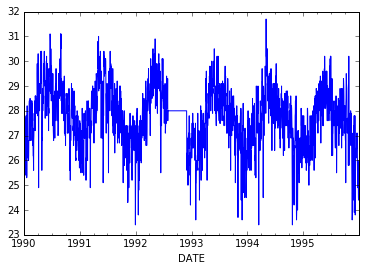

In [149]:
TTc.ForwardFill["1990":"1995"].plot()
plt.show()

### I-3-b Filling by Rolling Mean and Median

In [150]:
TTc = TTc.assign(FillMean=TTc.TAVE.fillna(TTc.TAVE_T.mean()))
TTc = TTc.assign(FillMedian=TTc.TAVE.fillna(TTc.TAVE_T.median()))
TTc = TTc.assign(RollingMean=TTc.TAVE_T.fillna(TTc.TAVE_T.rolling(122,min_periods=1,).mean()))
TTc = TTc.assign(RollingMedian=TTc.TAVE_T.fillna(TTc.TAVE_T.rolling(122,min_periods=1,).median()))


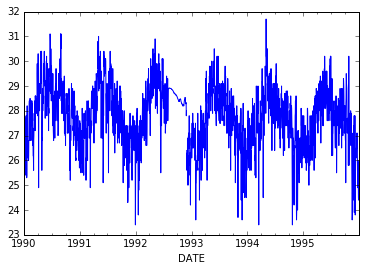

In [151]:
TTc.RollingMean["1990":"1995"].plot()
plt.show()

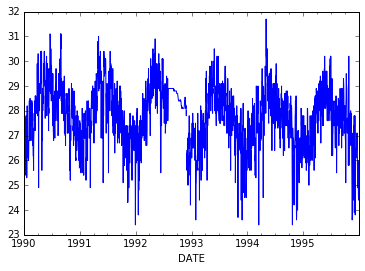

In [152]:
TTc.RollingMedian["1990":"1995"].plot()
plt.show()

### I-3-c Filling by Regressions

In [153]:
TTc = TTc.assign(InterpolateLinear=TTc.TAVE_T.interpolate(method='linear'))
TTc= TTc.assign(InterpolateTime=TTc.TAVE_T.interpolate(method='time'))
TTc = TTc.assign(InterpolateQuadratic=TTc.TAVE_T.interpolate(method='quadratic'))
TTc = TTc.assign(InterpolateCubic=TTc.TAVE_T.interpolate(method='cubic'))
TTc = TTc.assign(InterpolateSLinear=TTc.TAVE_T.interpolate(method='slinear'))
TTc = TTc.assign(InterpolateAkima=TTc.TAVE_T.interpolate(method='akima'))
TTc = TTc.assign(InterpolatePoly5=TTc.TAVE_T.interpolate(method='polynomial', order=5)) 
TTc = TTc.assign(InterpolatePoly7=TTc.TAVE_T.interpolate(method='polynomial', order=7))
TTc = TTc.assign(InterpolateSpline3=TTc.TAVE_T.interpolate(method='spline', order=3))
TTc = TTc.assign(InterpolateSpline4=TTc.TAVE_T.interpolate(method='spline', order=4))
TTc = TTc.assign(InterpolateSpline5=TTc.TAVE_T.interpolate(method='spline', order=5))

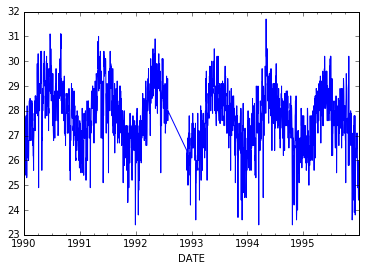

In [154]:
TTc.InterpolateTime["1990":"1995"].plot()
plt.show()

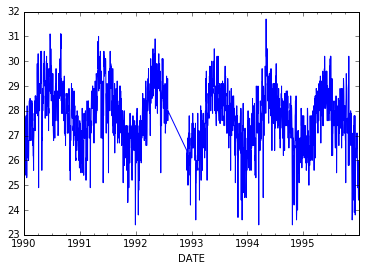

In [155]:
TTc.InterpolateSLinear["1990":"1995"].plot()
plt.show()

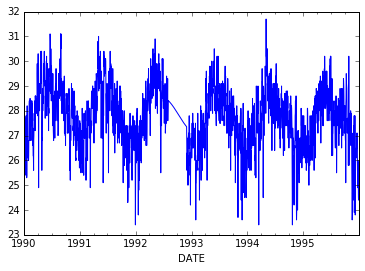

In [156]:
TTc.InterpolateSpline5["1990":"1995"].plot()
plt.show()

### I-3-d Filling big gap by rolling year

In [157]:
TTc.iloc[[1645]].index

DatetimeIndex(['1992-07-03'], dtype='datetime64[ns]', name='DATE', freq='D')

In [158]:
TTc.iloc[[1645+122]].index

DatetimeIndex(['1992-11-02'], dtype='datetime64[ns]', name='DATE', freq='D')

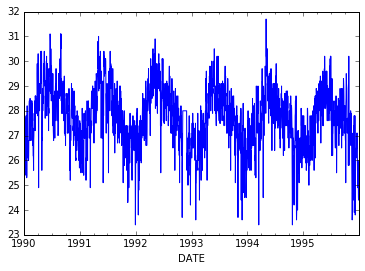

In [159]:
TTc.loc["1992-07-01":"1992-11-04",["ForwardFill"]]=TTc.TAVE_T.shift(periods=-365).loc["1992-07-01":"1992-11-04"]
TTc.ForwardFill["1990":"1995"].plot()
plt.show()

# II DATA ANALYSIS

## II-1 FOURIER ANALYSIS

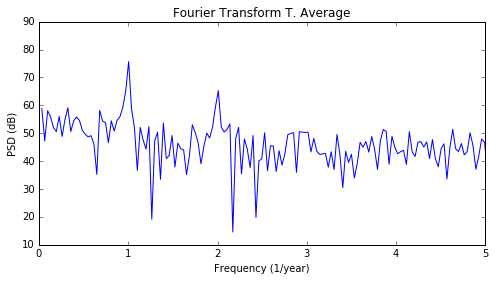

In [340]:
#Number of Sample points
N=len(x)
# Sample spacing
T=1/365

temp_fft = scipy.fftpack.fft(TTc.ForwardFill)
temp_psd = np.abs(temp_fft) ** 2
fftfreq = scipy.fftpack.fftfreq(len(temp_psd), T)
i = fftfreq > 0

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(fftfreq[i], 10 * np.log10(temp_psd[i]))
ax.set_xlim(0, 5)
ax.set_ylim(10, 90)
plt.title("Fourier Transform T. Average") 
ax.set_xlabel('Frequency (1/year)')
ax.set_ylabel('PSD (dB)')
plt.show()

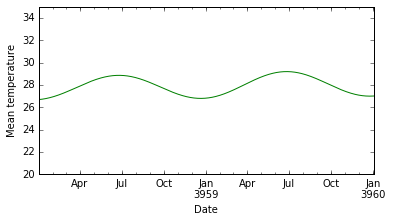

In [315]:
temp_fft_bis = temp_fft.copy()
temp_fft_bis[np.abs(fftfreq) > 1.1] = 0
temp_slow = np.real(scipy.fftpack.ifft(temp_fft_bis))

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
TTc.ForwardFill["1989-1-1":"1991-1-1"].plot(ax=ax,lw=0.5)

date = TTc.TAVE.index.to_datetime()
ax.plot_date(date, temp_slow, '-')
ax.set_xlim(datetime.date(1989, 1, 1),
            datetime.date(1991,1, 1))
ax.set_ylim(20, 35)
ax.set_xlabel('Date')
ax.set_ylabel('Mean temperature')
plt.show()

## II-2 MOVING AVERAGES

In [324]:
#Smooth moving average
TTc['pandas_SMA_4'] = TTc.ForwardFill.rolling(window=4).mean()
#Commulative Average
TTc['CMA_4'] = TTc.ForwardFill.expanding(min_periods=4).mean()
#Exponential Moving Average
TTc['EMA'] = TTc.ForwardFill.ewm(span=40,adjust=False).mean()

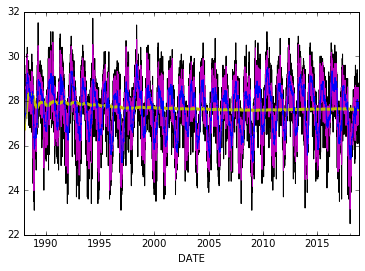

In [323]:
TTc.ForwardFill.plot(color="k")
TTc['pandas_SMA_4'].plot(color="m")
TTc['CMA_4'].plot(color="y",linewidth=3)
TTc['EMA'].plot(color="b")
plt.show()

## II-3 INTERPOLATION

In [339]:
l=np.arange(0,11262,1)
F1func=intr.UnivariateSpline(l,TTc.ForwardFill,k=5,s=0.1)

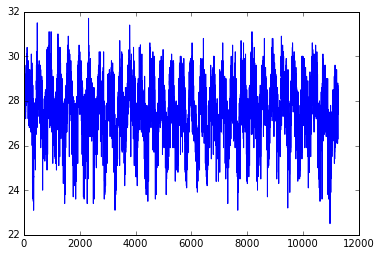

In [338]:
plt.plot(l,F1func(l))
plt.show()

## II-4 SEASONALITY

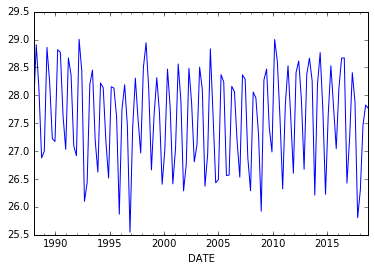

In [345]:
TTc.resample('90D').mean().TAVE.plot()
plt.show()